In [180]:
import numpy as np 
import pandas as pd 
import cv2
import scipy
import math
import os, random
from skimage.metrics import structural_similarity
from PIL import Image
from numpy import r_
from scipy import fftpack
from matplotlib import pyplot as plt
%matplotlib inline


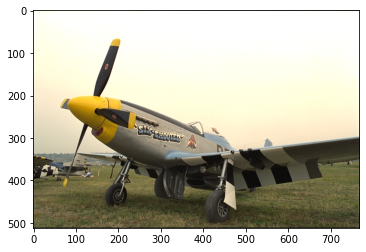

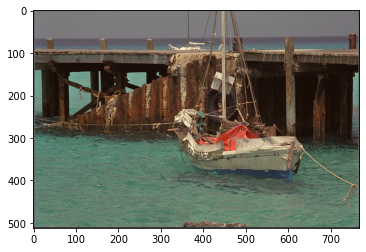

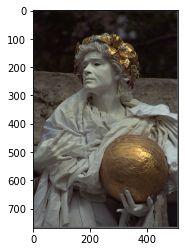

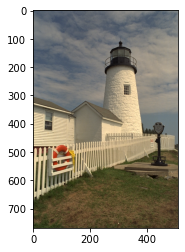

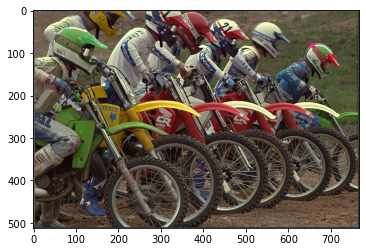

In [181]:
for i in range(5):
    randImagePath = os.path.join('Kodak/', np.random.choice((os.listdir("Kodak"))))
    img = Image.open(randImagePath)
    # img = cv2.imread(randImagePath)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f = plt.figure()
    plt.imshow(img)


In [182]:
def load_image(path):
    """ Load image from path. Return a numpy array """
    image = Image.open(path)
    return np.asarray(image) #/ 255

def showImage(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

def PlotGraphs(data, label_x):
  x=data[0]
  y=data[1]
  z=data[2]
  w=data[3]

  plt.scatter(x, y,c='red')
  plt.plot(x, y)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("CR")
  plt.show()

  plt.scatter(x, z,c='green')
  plt.plot(x, z)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("PSNR")
  plt.show()

  plt.scatter(x, w,c='blue')
  plt.plot(x, w)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("SSIM")
  plt.show()

In [211]:
def dct2(a):
    return fftpack.dct(fftpack.dct(a, axis=0, norm='ortho').T, axis=1, norm='ortho').T

def idct2(a):
    return fftpack.idct(fftpack.idct(a, axis=0 , norm='ortho').T, axis=1 , norm='ortho').T

# def dct2(a):
#     return cv2.dct(a)

# def idct2(a):
#     return cv2.dct(a, flags = 1)


def getLuminanceQuantizationMatrix(quality = 50):
    Q10 = np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])
    
    Q50 = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])

    Q90 = np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    if quality == 10:
        return Q10
    elif quality == 50:
        return Q50
    elif quality == 90:
        return Q90
    else:
        return np.ones((8,8))
    
def getChrominanceQuantizationMatrix(quality = 50):
    Q = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                  [18, 21, 26, 66, 99, 99, 99, 99],
                  [24, 26, 56, 99, 99, 99, 99, 99],
                  [47, 66, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99]], dtype=int)

    if(quality >= 100):
        return np.ones((8,8))
    if(quality <= 0):
        quality = 1
    if(quality < 50):
        qualityScale = 5000 / quality
    else:
        qualityScale = 200 - quality * 2
    chrominanceQuantTbl = np.array(np.floor((Q * qualityScale + 50) / 100))
    chrominanceQuantTbl[chrominanceQuantTbl == 0] = 1
    chrominanceQuantTbl[chrominanceQuantTbl > 255] = 255
    chrominanceQuantTbl = chrominanceQuantTbl.reshape([8, 8]).astype(int)
    return chrominanceQuantTbl

def DCT_compression(im, threshold, Lquality, Cquality):    

    imsize = im.shape
    Height = imsize[0]
    Width = imsize[1]
    srcImageMatrix = im
    addedImageMatrix = np.zeros(imsize, dtype=np.uint8)
    for y in range(Height):
        for x in range(Width):
            addedImageMatrix[y][x] = srcImageMatrix[y][x]
            
    yImage,uImage,vImage = Image.fromarray(addedImageMatrix).convert('YCbCr').split()
    yImageMatrix = np.asarray(yImage)
    uImageMatrix = np.asarray(uImage)
    vImageMatrix = np.asarray(vImage)

    LQ = getLuminanceQuantizationMatrix(Lquality)
    CQ = getChrominanceQuantizationMatrix(Cquality)
   
    # dct = np.zeros(imsize)
    
    # Do 8x8 DCT on image (in-place)
    # for i in r_[:imsize[0]:8]:
    #     for j in r_[:imsize[1]:8]:
    #         dct[i:(i+8),j:(j+8)] = dct2( im[i:(i+8),j:(j+8)])

    yDctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uDctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vDctMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)

    Y_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)
    U_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)
    V_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)

    
    for y in range(0, Height, 8):
        for x in range(0, Width, 8):
            yDctMatrix[y:y + 8, x:x + 8] = dct2(yImageMatrix[y:y + 8, x:x + 8])
            uDctMatrix[y:y + 8, x:x + 8] = dct2(uImageMatrix[y:y + 8, x:x + 8])
            vDctMatrix[y:y + 8, x:x + 8] = dct2(vImageMatrix[y:y + 8, x:x + 8])

            yQuantMatrix[y:y + 8, x:x + 8] = yDctMatrix[y:y + 8, x:x + 8] // LQ
            uQuantMatrix[y:y + 8, x:x + 8] = uDctMatrix[y:y + 8, x:x + 8] // CQ
            vQuantMatrix[y:y + 8, x:x + 8] = vDctMatrix[y:y + 8, x:x + 8] // CQ

    #  Threshold
    Y_dct_thresh = yQuantMatrix * (abs(yQuantMatrix) > (threshold*np.max(yQuantMatrix)))
    percent_nonzeros = np.sum( Y_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(round(percent_nonzeros*100.0, 2))+" % of the DCT coefficients of Y Matrix")


    U_dct_thresh = uQuantMatrix * (abs(uQuantMatrix) > (threshold*np.max(uQuantMatrix)))
    percent_nonzeros = np.sum( U_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(round(percent_nonzeros*100.0, 2))+" % of the DCT coefficients of U Matrix")


    V_dct_thresh = vQuantMatrix * (abs(vQuantMatrix) > (threshold*np.max(vQuantMatrix)))
    percent_nonzeros = np.sum( V_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(round(percent_nonzeros*100.0, 2))+" % of the DCT coefficients of V Matrix")

    # im_dct = np.zeros(imsize)#regained image

    # for i in r_[:imsize[0]:8]:
    #     for j in r_[:imsize[1]:8]:
    #         im_dct[i:(i+8),j:(j+8)] = idct2(dct_thresh[i:(i+8),j:(j+8)]) 

    # im_dct = im_dct.astype(np.uint8)
    # return im_dct

    for y in range(0, Height, 8):
        for x in range(0, Width, 8):
            yReversedQuantMatrix[y:y + 8, x:x + 8] = Y_dct_thresh[y:y + 8, x:x + 8]*LQ
            uReversedQuantMatrix[y:y + 8, x:x + 8] = U_dct_thresh[y:y + 8, x:x + 8]*CQ
            vReversedQuantMatrix[y:y + 8, x:x + 8] = V_dct_thresh[y:y + 8, x:x + 8]*CQ

            yIdctMatrix[y:y + 8, x:x + 8] = idct2(yReversedQuantMatrix[y:y + 8, x:x + 8])
            uIdctMatrix[y:y + 8, x:x + 8] = idct2(uReversedQuantMatrix[y:y + 8, x:x + 8])
            vIdctMatrix[y:y + 8, x:x + 8] = idct2(vReversedQuantMatrix[y:y + 8, x:x + 8])

    Y = Image.fromarray(yIdctMatrix)
    U = Image.fromarray(uIdctMatrix)
    V = Image.fromarray(vIdctMatrix)
    
    merged_YUV = Image.merge('YCbCr', (Y, U, V)) 
    rgb_img = merged_YUV.convert('RGB') 
    
    return rgb_img

    


In [221]:
def psnr(original, compressed):
    mse = np.mean( (original - compressed) ** 2 )
    if mse == 0:
        return 100 
    PIXEL_MAX = 255.0
    return round((20 * math.log10(PIXEL_MAX / math.sqrt(mse))), 3)

def ssim(original, compressed):
    meanSSIM = structural_similarity(original, compressed, multichannel=True)
    return round(meanSSIM, 3) 
    
def cr2(original, compressed):
    nonZerosInOriginal = np.sum(original!=0)
    nonZerosInCompressed = np.sum(compressed!=0)
    return round(nonZerosInOriginal/nonZerosInCompressed, 3)
    
def cr(original_img, compressed_img):
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB)

    original_img=cv2.imwrite("original.png", original_img)
    print("Original File Size: "+str(os.path.getsize("original.png")))
    
    compressed_img=cv2.imwrite("compressed.png", compressed_img)
    print("Compressed File Size: "+str(os.path.getsize("compressed.png")))

    return round(os.path.getsize("original.png")/os.path.getsize("compressed.png"), 3)
    
def metrics( original_img, compressed_img ):
    print("Achieved Peak Signal to Noise Ratio: " + str(psnr(original_img, compressed_img)))
    print("Achieved SSIM : " + str(ssim(original_img, compressed_img)))
    print("Achieved Compression Ratio: " + str(cr(original_img, compressed_img)))  
    print("CR 2 = ", cr2(original_img, compressed_img))
    return cr(original_img, compressed_img), psnr(original_img, compressed_img), ssim(original_img, compressed_img)

Keeping only 30.31 % of the DCT coefficients of Y Matrix
Keeping only 63.16 % of the DCT coefficients of U Matrix
Keeping only 63.05 % of the DCT coefficients of V Matrix
(512, 768, 3)
1179648
(512, 768, 3)
1179648
Achieved Peak Signal to Noise Ratio: 27.918
Achieved SSIM : 0.157
Original File Size: 915652
Compressed File Size: 793253
Achieved Compression Ratio: 1.154
CR 2 =  1.368
Original File Size: 915652
Compressed File Size: 793253


(1.154, 27.918, 0.157)

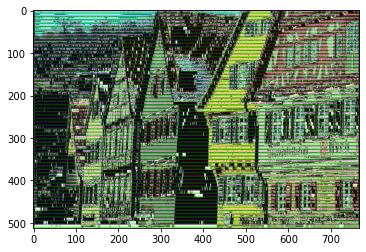

In [225]:
image = load_image("Kodak/kodim08.png")
# X_final= np.asarray(DCT_compression( image, 0.01,), dtype=None, order=None)
X_final = np.asarray(DCT_compression(image, 0.5, 100, 100))
print(image.shape)
print(image.size)
print(X_final.shape)
print(X_final.size)
plt.imshow(X_final)
metrics( image, X_final )


Testing for threshold = 0.0
Keeping only 99.74416097005209 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 32.05
Achieved SSIM : 0.7
Compressed File Size: 943171
Original File Size: 915652
Achieved Compression Ratio: 0.97
Compressed File Size: 943171
Original File Size: 915652
Testing for threshold = 0.1
Keeping only 90.31600952148438 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99974568684897 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 31.45
Achieved SSIM : 0.65
Compressed File Size: 951922
Original File Size: 915652
Achieved Compression Ratio: 0.96
Compressed File Size: 951922
Original File Size: 915652
Testing for threshold = 0.2
Keeping only 74.57300821940103 % of the DCT coefficients of Y Matrix
Keeping only 87.

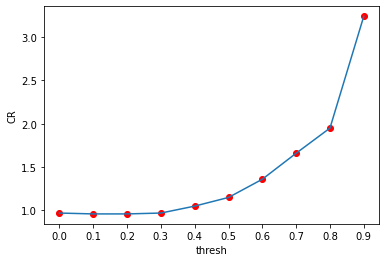

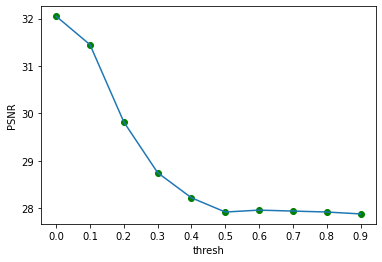

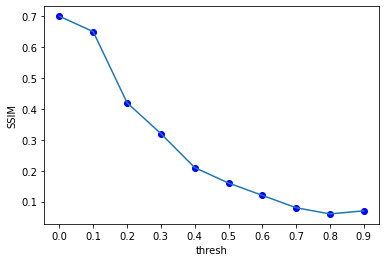

In [208]:
image = load_image("Kodak/kodim08.png")
thresh = 0.0
threshMax = 0.9
step = 0.1
i=0
noOfMetrics = 3 
eval_data = np.zeros(((int((threshMax-thresh)/step))+1, noOfMetrics + 1), dtype=float)#col1=thresh, col2=cr, col3=psnr, col4=ssim
while thresh<=threshMax:
  eval_data[i][0] = thresh
  print("Testing for threshold = "+str(thresh))
  X_compressed = np.asarray(DCT_compression(image, thresh, 100, 100), dtype=None, order=None )#DCT Transform 
  print("Metrics otained: ")
  eval_data[i][1], eval_data[i][2], eval_data[i][3] = metrics( image, X_compressed )
  thresh+=0.1
  i+=1
print("Data obtained after evaluation: ")
print(eval_data)
PlotGraphs(np.ndarray.transpose(eval_data), 'thresh')

Keeping only 99.86317952473959 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.19276415709159
Achieved SSIM : 0.9054018188710188
Compressed File Size: 877980
Original File Size: 857993
Achieved Compression Ratio: 0.9772352445386
Compressed File Size: 877980
Original File Size: 857993
Keeping only 93.487548828125 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.218749348149416
Achieved SSIM : 0.8471053738978084
Compressed File Size: 886691
Original File Size: 857993
Achieved Compression Ratio: 0.9676347228064793
Compressed File Size: 886691
Original File Size: 857993
Keeping only 79.97461954752603 % of the DCT coefficients of Y Matrix
Keeping only 87.73015340169272 % of

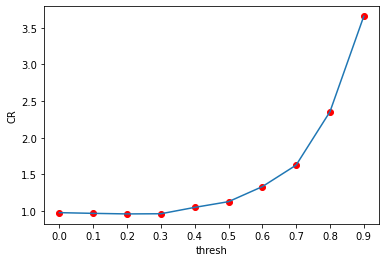

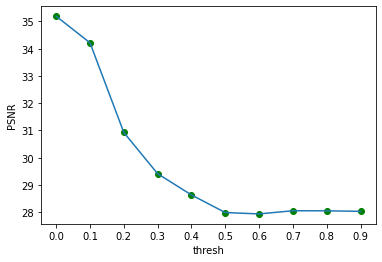

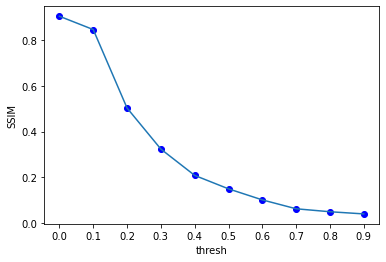

Keeping only 99.94379679361978 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.80926513671875 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.45976358547952
Achieved SSIM : 0.9010750977908852
Compressed File Size: 711278
Original File Size: 681895
Achieved Compression Ratio: 0.9586898512255405
Compressed File Size: 711278
Original File Size: 681895
Keeping only 88.58642578125 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.46034749348959 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.7487711081929
Achieved SSIM : 0.6794318853305191
Compressed File Size: 720461
Original File Size: 681895
Achieved Compression Ratio: 0.9464703849340909
Compressed File Size: 720461
Original File Size: 681895
Keeping only 72.61683146158853 % of the DCT coefficients of Y Matrix
Keeping onl

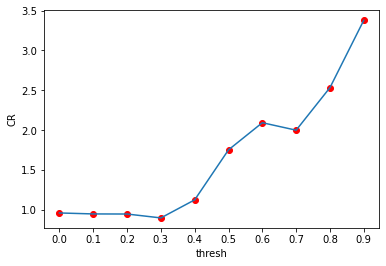

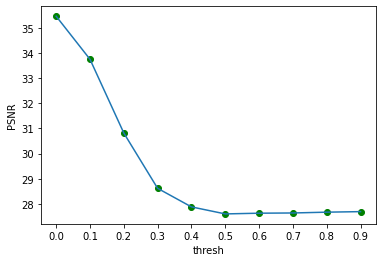

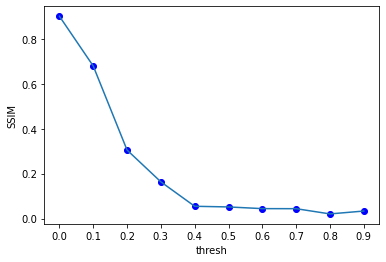

Keeping only 99.95168050130209 % of the DCT coefficients of Y Matrix
Keeping only 99.98906453450522 % of the DCT coefficients of U Matrix
Keeping only 99.97660319010416 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.12699227611271
Achieved SSIM : 0.9039392262807331
Compressed File Size: 622051
Original File Size: 591916
Achieved Compression Ratio: 0.9515554190894315
Compressed File Size: 622051
Original File Size: 591916
Keeping only 92.39247639973959 % of the DCT coefficients of Y Matrix
Keeping only 98.00949096679688 % of the DCT coefficients of U Matrix
Keeping only 99.40312703450522 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.90010181498549
Achieved SSIM : 0.7390813534949686
Compressed File Size: 639019
Original File Size: 591916
Achieved Compression Ratio: 0.9262885767089868
Compressed File Size: 639019
Original File Size: 591916
Keeping only 75.75785319010416 % of the DCT coeffici

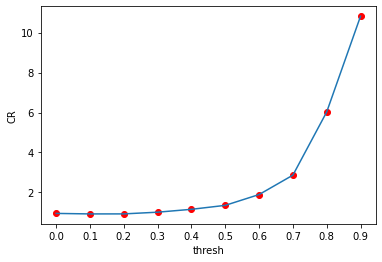

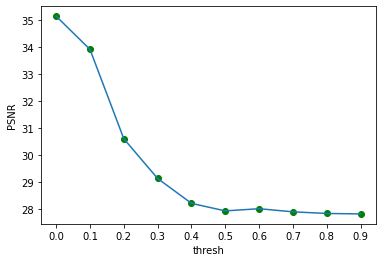

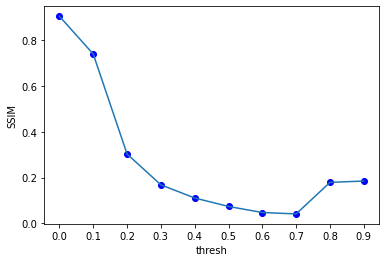

Keeping only 99.72763061523438 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.94150797526041 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.17857749175468
Achieved SSIM : 0.9144052657127046
Compressed File Size: 732593
Original File Size: 711269
Achieved Compression Ratio: 0.9708924327696279
Compressed File Size: 732593
Original File Size: 711269
Keeping only 91.92708333333334 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.13304646809897 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.043863744836415
Achieved SSIM : 0.8022965894596611
Compressed File Size: 750427
Original File Size: 711269
Achieved Compression Ratio: 0.9478190416922632
Compressed File Size: 750427
Original File Size: 711269
Keeping only 74.91785685221353 % of the DCT coefficients of Y Matrix
Keepin

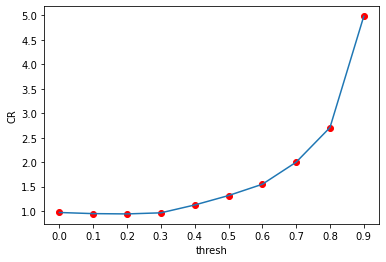

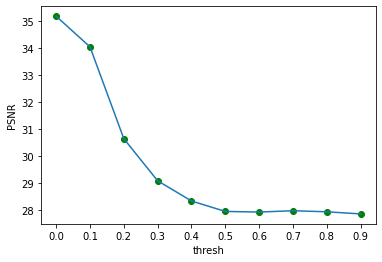

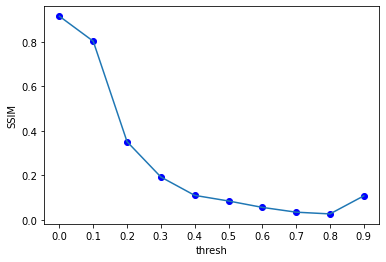

Keeping only 99.46543375651041 % of the DCT coefficients of Y Matrix
Keeping only 99.99923706054688 % of the DCT coefficients of U Matrix
Keeping only 99.99491373697916 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.43237628809267
Achieved SSIM : 0.7156620095649164
Compressed File Size: 906686
Original File Size: 866515
Achieved Compression Ratio: 0.9556946947454797
Compressed File Size: 906686
Original File Size: 866515
Keeping only 84.34804280598959 % of the DCT coefficients of Y Matrix
Keeping only 99.71745808919272 % of the DCT coefficients of U Matrix
Keeping only 99.86495971679688 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 31.95211260335696
Achieved SSIM : 0.6015133923408599
Compressed File Size: 920737
Original File Size: 866515
Achieved Compression Ratio: 0.9411102193134413
Compressed File Size: 920737
Original File Size: 866515
Keeping only 62.59333292643229 % of the DCT coeffici

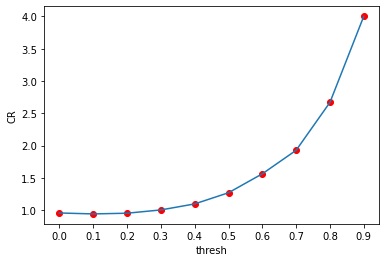

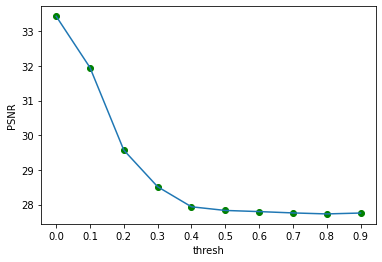

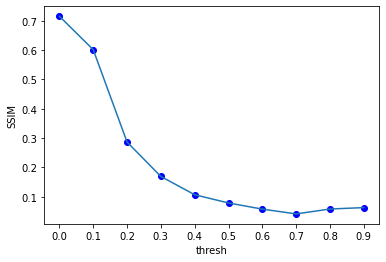

Keeping only 99.81816609700522 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 32.12719914178076
Achieved SSIM : 0.7195450808928329
Compressed File Size: 752381
Original File Size: 717532
Achieved Compression Ratio: 0.9536817117922968
Compressed File Size: 752381
Original File Size: 717532
Keeping only 92.86982218424478 % of the DCT coefficients of Y Matrix
Keeping only 99.99516805013022 % of the DCT coefficients of U Matrix
Keeping only 99.99923706054688 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 31.651092304870527
Achieved SSIM : 0.6661359512340763
Compressed File Size: 763241
Original File Size: 717532
Achieved Compression Ratio: 0.9401119698758321
Compressed File Size: 763241
Original File Size: 717532
Keeping only 80.68822224934897 % of the DCT coefficients of Y Matrix
Keepin

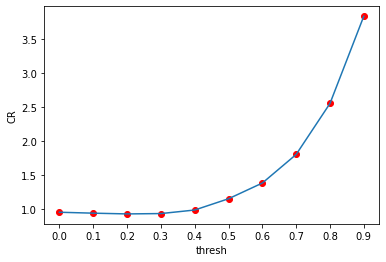

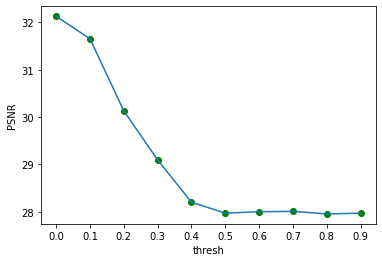

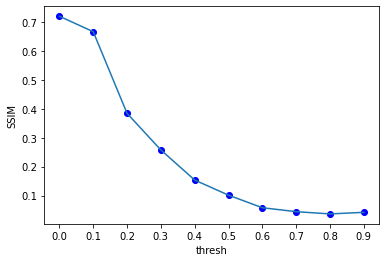

Keeping only 99.84614054361978 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.98855590820312 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.02429961971166
Achieved SSIM : 0.8961828655350641
Compressed File Size: 668857
Original File Size: 635563
Achieved Compression Ratio: 0.9502225438322391
Compressed File Size: 668857
Original File Size: 635563
Keeping only 94.5770263671875 % of the DCT coefficients of Y Matrix
Keeping only 99.96465047200522 % of the DCT coefficients of U Matrix
Keeping only 99.73271687825522 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.34757856801599
Achieved SSIM : 0.8522525108976069
Compressed File Size: 676970
Original File Size: 635563
Achieved Compression Ratio: 0.9388348080417153
Compressed File Size: 676970
Original File Size: 635563
Keeping only 79.54737345377603 % of the DCT coefficients of Y Mat

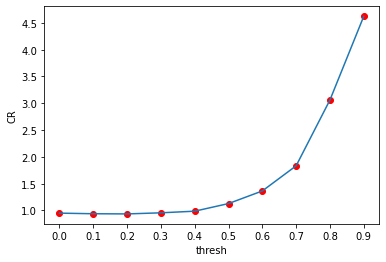

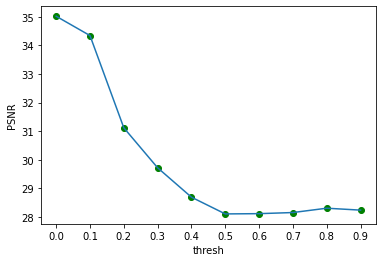

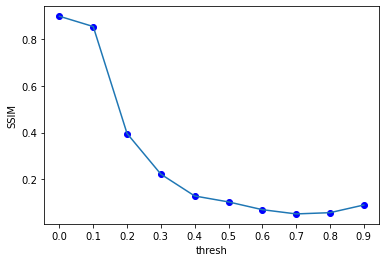

Keeping only 99.74416097005209 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 32.04739385956165
Achieved SSIM : 0.696886455418837
Compressed File Size: 943171
Original File Size: 915652
Achieved Compression Ratio: 0.9708228942577751
Compressed File Size: 943171
Original File Size: 915652
Keeping only 90.31600952148438 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99974568684897 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 31.454456640411166
Achieved SSIM : 0.6454145289508112
Compressed File Size: 951922
Original File Size: 915652
Achieved Compression Ratio: 0.9618981387130459
Compressed File Size: 951922
Original File Size: 915652
Keeping only 74.57300821940103 % of the DCT coefficients of Y Matrix
Keeping only 87.513

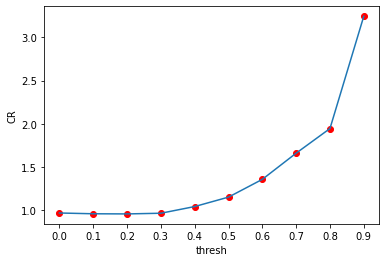

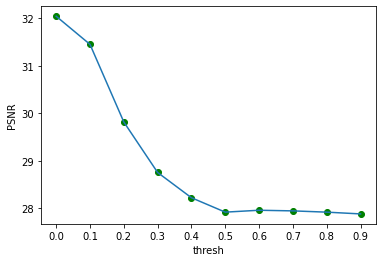

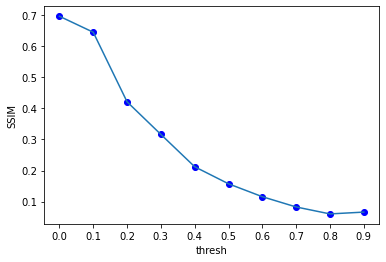

Keeping only 99.70016479492188 % of the DCT coefficients of Y Matrix
Keeping only 99.99745686848959 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.93652541200523
Achieved SSIM : 0.8877473583839409
Compressed File Size: 689420
Original File Size: 660256
Achieved Compression Ratio: 0.957697774941255
Compressed File Size: 689420
Original File Size: 660256
Keeping only 95.65938313802084 % of the DCT coefficients of Y Matrix
Keeping only 99.56207275390625 % of the DCT coefficients of U Matrix
Keeping only 99.98092651367188 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.352480815560476
Achieved SSIM : 0.846280320597638
Compressed File Size: 695995
Original File Size: 660256
Achieved Compression Ratio: 0.9486504931788303
Compressed File Size: 695995
Original File Size: 660256
Keeping only 82.4981689453125 % of the DCT coefficients of Y Matr

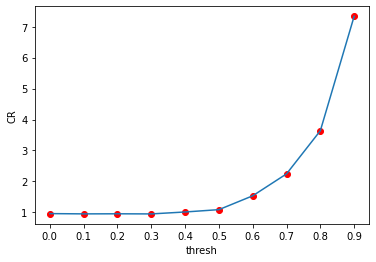

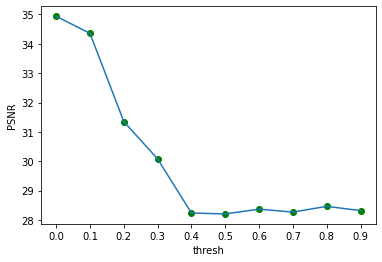

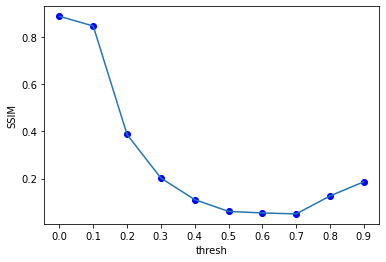

Keeping only 99.68694051106772 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99949137369791 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.244709612044616
Achieved SSIM : 0.9009269747077945
Compressed File Size: 703110
Original File Size: 677636
Achieved Compression Ratio: 0.9637695381945925
Compressed File Size: 703110
Original File Size: 677636
Keeping only 95.25731404622397 % of the DCT coefficients of Y Matrix
Keeping only 99.98372395833334 % of the DCT coefficients of U Matrix
Keeping only 99.96770222981772 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.530529685804275
Achieved SSIM : 0.8484331562076473
Compressed File Size: 716097
Original File Size: 677636
Achieved Compression Ratio: 0.9462907958000103
Compressed File Size: 716097
Original File Size: 677636
Keeping only 81.44124348958334 % of the DCT coefficients of Y 

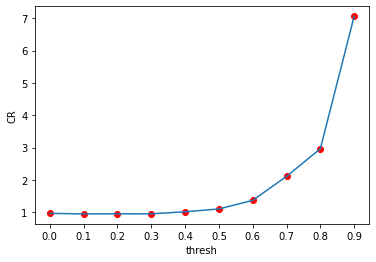

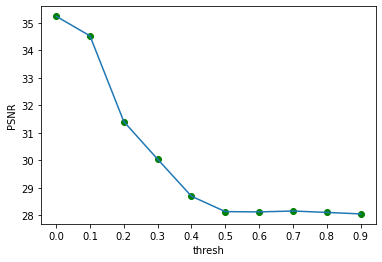

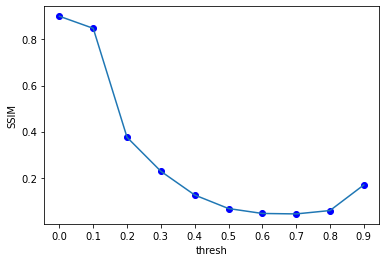

Keeping only 99.84130859375 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99593098958334 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.317588057678634
Achieved SSIM : 0.8940574901570727
Compressed File Size: 740906
Original File Size: 716472
Achieved Compression Ratio: 0.9670214575128289
Compressed File Size: 740906
Original File Size: 716472
Keeping only 84.65957641601562 % of the DCT coefficients of Y Matrix
Keeping only 99.99720255533853 % of the DCT coefficients of U Matrix
Keeping only 99.92294311523438 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.04564729086225
Achieved SSIM : 0.7645068308143106
Compressed File Size: 734535
Original File Size: 716472
Achieved Compression Ratio: 0.9754089321815843
Compressed File Size: 734535
Original File Size: 716472
Keeping only 68.84562174479166 % of the DCT coefficients of Y Matr

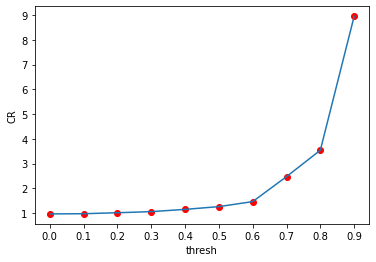

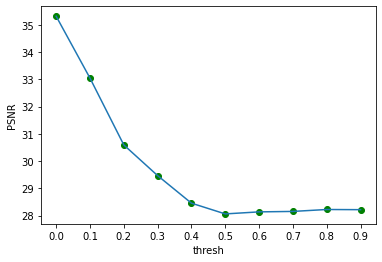

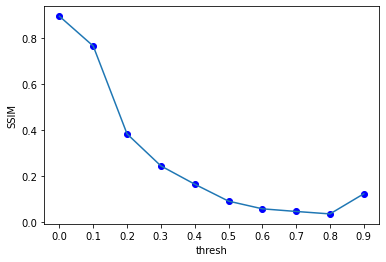

Keeping only 99.84563191731772 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99364217122397 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 31.996481627784274
Achieved SSIM : 0.7030959111167885
Compressed File Size: 668469
Original File Size: 619365
Achieved Compression Ratio: 0.9265425921022515
Compressed File Size: 668469
Original File Size: 619365
Keeping only 94.68434651692709 % of the DCT coefficients of Y Matrix
Keeping only 99.97227986653647 % of the DCT coefficients of U Matrix
Keeping only 99.96261596679688 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 31.742352386750824
Achieved SSIM : 0.6723265510545936
Compressed File Size: 672535
Original File Size: 619365
Achieved Compression Ratio: 0.9209409175730631
Compressed File Size: 672535
Original File Size: 619365
Keeping only 83.11894734700522 % of the DCT coefficients of Y 

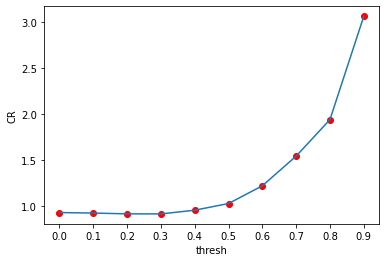

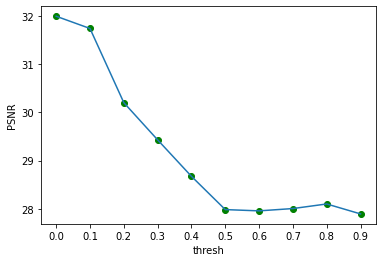

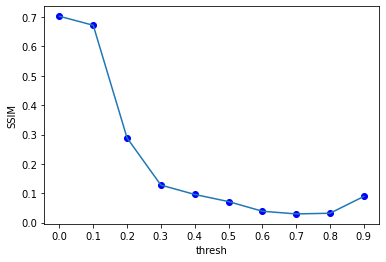

Keeping only 99.73068237304688 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.28031047731671
Achieved SSIM : 0.7736958728380774
Compressed File Size: 954945
Original File Size: 923532
Achieved Compression Ratio: 0.9671049118012032
Compressed File Size: 954945
Original File Size: 923532
Keeping only 90.76639811197916 % of the DCT coefficients of Y Matrix
Keeping only 99.67702229817709 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 32.465510621704624
Achieved SSIM : 0.7371482019665149
Compressed File Size: 966597
Original File Size: 923532
Achieved Compression Ratio: 0.9554467890961796
Compressed File Size: 966597
Original File Size: 923532
Keeping only 75.37689208984375 % of the DCT coefficients of Y Matrix
Keeping only 87.24

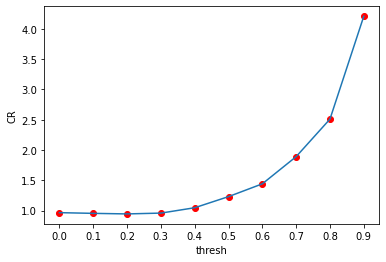

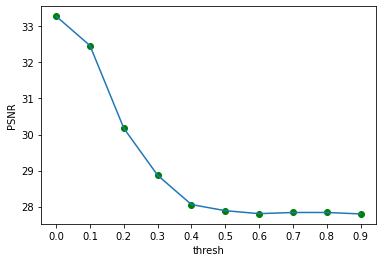

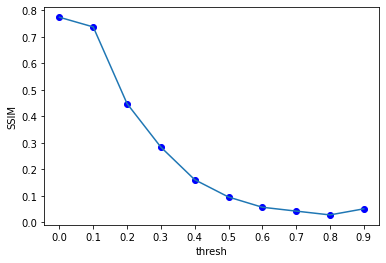

Keeping only 99.75204467773438 % of the DCT coefficients of Y Matrix
Keeping only 99.98855590820312 % of the DCT coefficients of U Matrix
Keeping only 99.98550415039062 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.74576067033563
Achieved SSIM : 0.85520781221516
Compressed File Size: 813690
Original File Size: 784496
Achieved Compression Ratio: 0.9641214713220022
Compressed File Size: 813690
Original File Size: 784496
Keeping only 87.33342488606772 % of the DCT coefficients of Y Matrix
Keeping only 98.05959065755209 % of the DCT coefficients of U Matrix
Keeping only 99.62336222330728 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 32.923135925402704
Achieved SSIM : 0.7337680918771001
Compressed File Size: 830372
Original File Size: 784496
Achieved Compression Ratio: 0.9447524723858705
Compressed File Size: 830372
Original File Size: 784496
Keeping only 67.63356526692709 % of the DCT coefficie

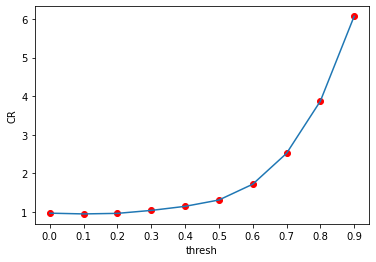

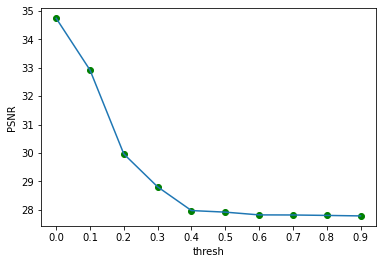

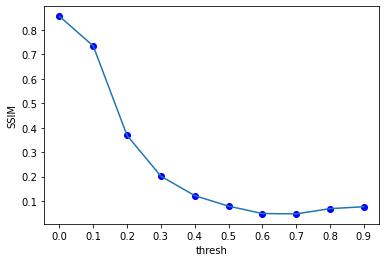

Keeping only 99.69278971354166 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.93921915690103 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 31.236522039681525
Achieved SSIM : 0.5931447556188681
Compressed File Size: 738088
Original File Size: 695984
Achieved Compression Ratio: 0.942955311561765
Compressed File Size: 738088
Original File Size: 695984
Keeping only 79.60357666015625 % of the DCT coefficients of Y Matrix
Keeping only 99.92243448893228 % of the DCT coefficients of U Matrix
Keeping only 98.64679972330728 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 30.039647094901664
Achieved SSIM : 0.3950911876255144
Compressed File Size: 746759
Original File Size: 695984
Achieved Compression Ratio: 0.932006176021983
Compressed File Size: 746759
Original File Size: 695984
Keeping only 57.329813639322914 % of the DCT coefficients of Y M

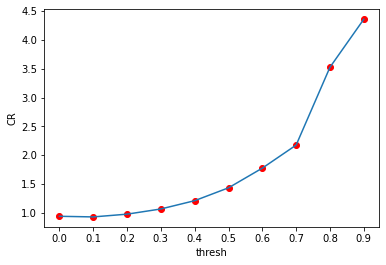

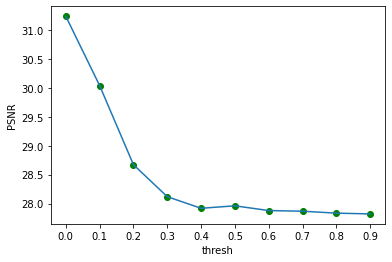

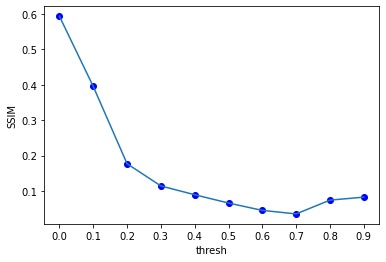

Keeping only 99.84563191731772 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.72654439030611
Achieved SSIM : 0.8681141539010987
Compressed File Size: 667747
Original File Size: 631496
Achieved Compression Ratio: 0.9457114745554829
Compressed File Size: 667747
Original File Size: 631496
Keeping only 93.12566121419272 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.79329609097602
Achieved SSIM : 0.8076616177995478
Compressed File Size: 682853
Original File Size: 631496
Achieved Compression Ratio: 0.9247905478924454
Compressed File Size: 682853
Original File Size: 631496
Keeping only 75.74208577473959 % of the DCT coefficients of Y Matrix
Keeping only 87.53992716471353 

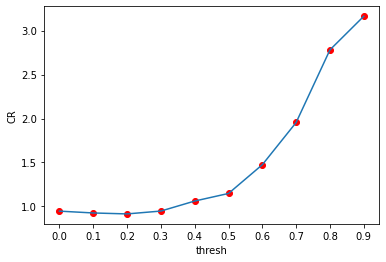

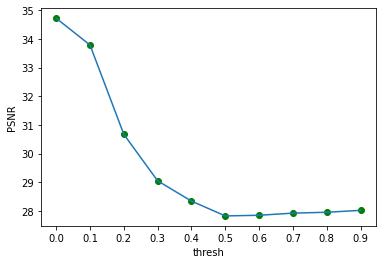

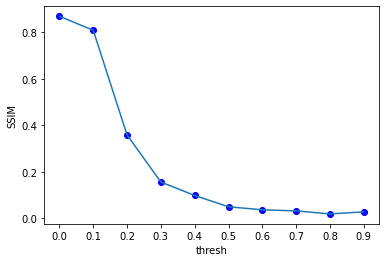

Keeping only 99.71440633138022 % of the DCT coefficients of Y Matrix
Keeping only 99.99974568684897 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.957995300644875
Achieved SSIM : 0.910915204296192
Compressed File Size: 713481
Original File Size: 687829
Achieved Compression Ratio: 0.9640466950065945
Compressed File Size: 713481
Original File Size: 687829
Keeping only 73.32992553710938 % of the DCT coefficients of Y Matrix
Keeping only 99.94888305664062 % of the DCT coefficients of U Matrix
Keeping only 99.99796549479166 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 31.840495381733774
Achieved SSIM : 0.6432445991313535
Compressed File Size: 693474
Original File Size: 687829
Achieved Compression Ratio: 0.9918598245932796
Compressed File Size: 693474
Original File Size: 687829
Keeping only 56.029510498046875 % of the DCT coefficients of Y 

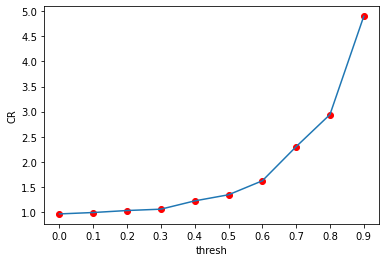

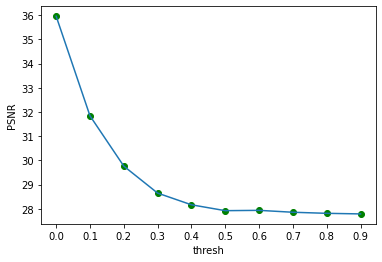

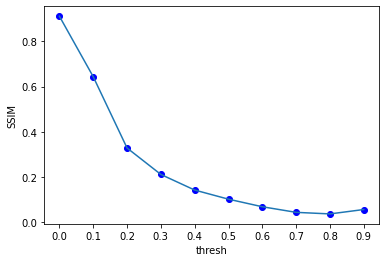

Keeping only 99.67397054036459 % of the DCT coefficients of Y Matrix
Keeping only 99.99898274739584 % of the DCT coefficients of U Matrix
Keeping only 99.99949137369791 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.154116629259214
Achieved SSIM : 0.8379360980439086
Compressed File Size: 862261
Original File Size: 837591
Achieved Compression Ratio: 0.9713891733477451
Compressed File Size: 862261
Original File Size: 837591
Keeping only 82.89031982421875 % of the DCT coefficients of Y Matrix
Keeping only 98.91331990559897 % of the DCT coefficients of U Matrix
Keeping only 99.98753865559897 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 32.6827632347749
Achieved SSIM : 0.6549666837546695
Compressed File Size: 880276
Original File Size: 837591
Achieved Compression Ratio: 0.9515095265575797
Compressed File Size: 880276
Original File Size: 837591
Keeping only 58.65503946940104 % of the DCT coeffici

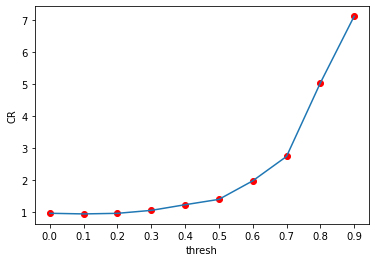

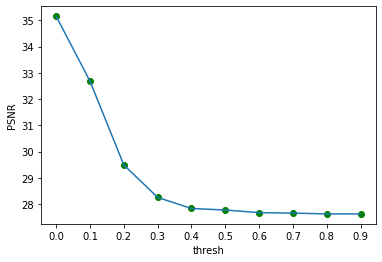

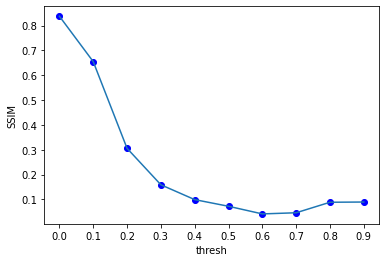

Keeping only 99.83952840169272 % of the DCT coefficients of Y Matrix
Keeping only 99.99949137369791 % of the DCT coefficients of U Matrix
Keeping only 99.99796549479166 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.91949160832772
Achieved SSIM : 0.8402278898611861
Compressed File Size: 772539
Original File Size: 748039
Achieved Compression Ratio: 0.9682863907194329
Compressed File Size: 772539
Original File Size: 748039
Keeping only 93.10277303059897 % of the DCT coefficients of Y Matrix
Keeping only 99.98448689778647 % of the DCT coefficients of U Matrix
Keeping only 99.97355143229166 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.23294439098974
Achieved SSIM : 0.7771527091048033
Compressed File Size: 787779
Original File Size: 748039
Achieved Compression Ratio: 0.9495543800989872
Compressed File Size: 787779
Original File Size: 748039
Keeping only 78.31344604492188 % of the DCT coeffici

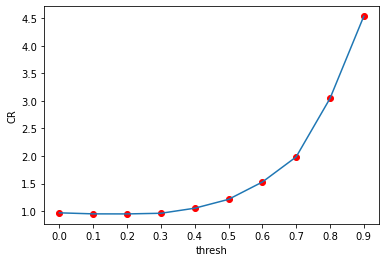

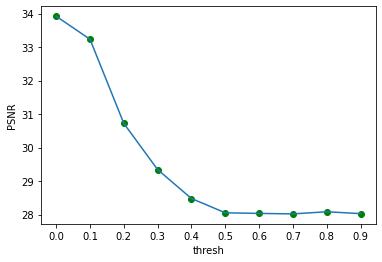

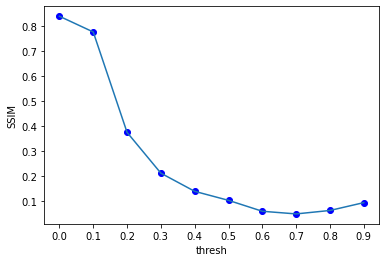

Keeping only 99.83774820963541 % of the DCT coefficients of Y Matrix
Keeping only 99.99796549479166 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 29.555644132180802
Achieved SSIM : 0.38580341230523985
Compressed File Size: 610123
Original File Size: 546270
Achieved Compression Ratio: 0.8953440535760822
Compressed File Size: 610123
Original File Size: 546270
Keeping only 91.94310506184897 % of the DCT coefficients of Y Matrix
Keeping only 99.61878458658853 % of the DCT coefficients of U Matrix
Keeping only 99.99872843424478 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 29.198088397807386
Achieved SSIM : 0.3196619515643845
Compressed File Size: 618375
Original File Size: 546270
Achieved Compression Ratio: 0.8833959975742874
Compressed File Size: 618375
Original File Size: 546270
Keeping only 76.03123982747397 % of the DCT coefficients of Y

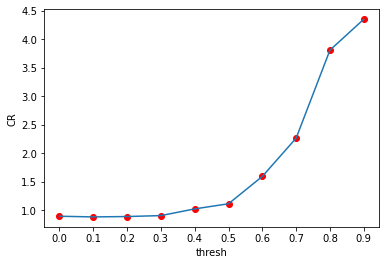

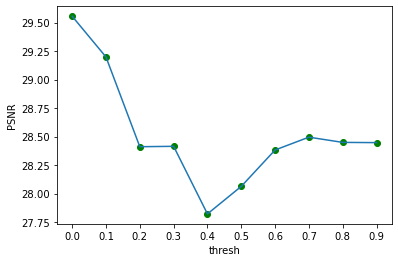

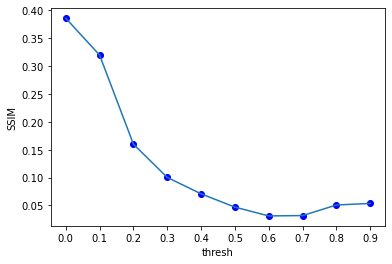

Keeping only 99.81892903645834 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.87880296781757
Achieved SSIM : 0.8850330433282304
Compressed File Size: 737188
Original File Size: 712184
Achieved Compression Ratio: 0.9660819221148472
Compressed File Size: 737188
Original File Size: 712184
Keeping only 94.37917073567709 % of the DCT coefficients of Y Matrix
Keeping only 99.98346964518228 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.12332407907977
Achieved SSIM : 0.8513113478198812
Compressed File Size: 745250
Original File Size: 712184
Achieved Compression Ratio: 0.9556309963099631
Compressed File Size: 745250
Original File Size: 712184
Keeping only 79.52855428059897 % of the DCT coefficients of Y Matrix
Keeping only 87.515

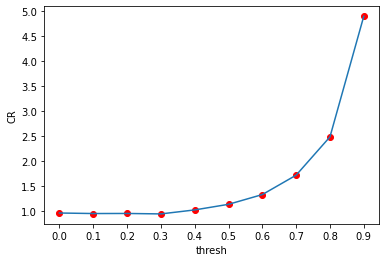

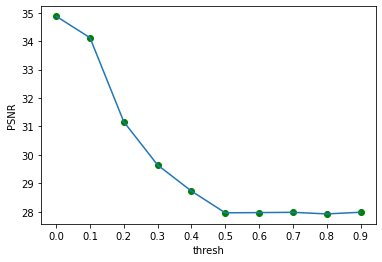

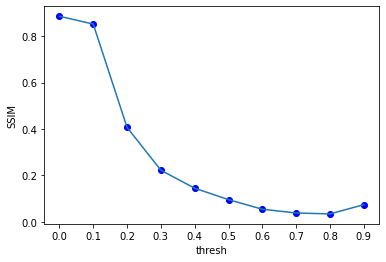

Keeping only 99.9267578125 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 99.99211629231772 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 35.2744235880021
Achieved SSIM : 0.9140614923098349
Compressed File Size: 788141
Original File Size: 773105
Achieved Compression Ratio: 0.9809221953939714
Compressed File Size: 788141
Original File Size: 773105
Keeping only 93.92242431640625 % of the DCT coefficients of Y Matrix
Keeping only 99.9786376953125 % of the DCT coefficients of U Matrix
Keeping only 99.8931884765625 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.352843142586444
Achieved SSIM : 0.8408976903018962
Compressed File Size: 800262
Original File Size: 773105
Achieved Compression Ratio: 0.9660648637571195
Compressed File Size: 800262
Original File Size: 773105
Keeping only 79.88306681315103 % of the DCT coefficients of Y Matrix
K

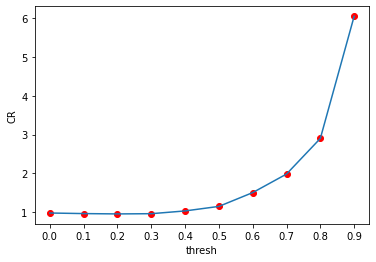

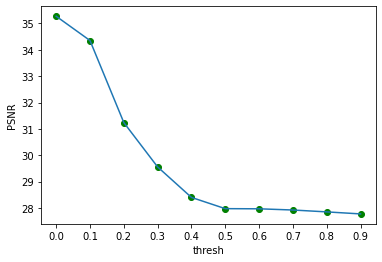

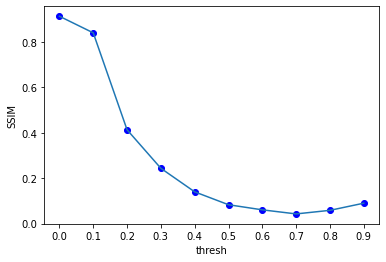

Keeping only 99.91175333658853 % of the DCT coefficients of Y Matrix
Keeping only 99.99720255533853 % of the DCT coefficients of U Matrix
Keeping only 99.96134440104166 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.73421028030648
Achieved SSIM : 0.831504747437858
Compressed File Size: 657517
Original File Size: 625778
Achieved Compression Ratio: 0.9517290047253532
Compressed File Size: 657517
Original File Size: 625778
Keeping only 92.30244954427084 % of the DCT coefficients of Y Matrix
Keeping only 96.65501912434897 % of the DCT coefficients of U Matrix
Keeping only 99.03971354166666 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 32.836248033425235
Achieved SSIM : 0.6525065850945649
Compressed File Size: 677210
Original File Size: 625778
Achieved Compression Ratio: 0.9240531002200204
Compressed File Size: 677210
Original File Size: 625778
Keeping only 77.33103434244791 % of the DCT coeffici

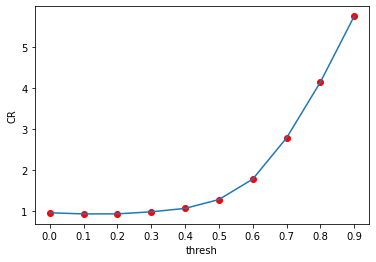

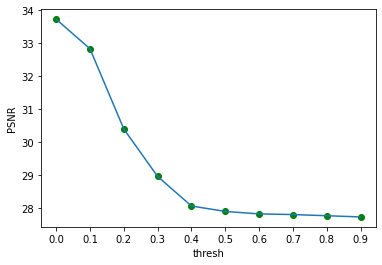

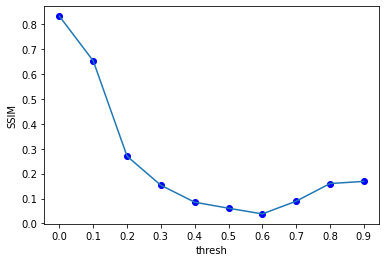

Keeping only 99.87080891927084 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.226742807772744
Achieved SSIM : 0.8626696218023632
Compressed File Size: 819488
Original File Size: 788470
Achieved Compression Ratio: 0.9621495372720528
Compressed File Size: 819488
Original File Size: 788470
Keeping only 91.83807373046875 % of the DCT coefficients of Y Matrix
Keeping only 99.90895589192709 % of the DCT coefficients of U Matrix
Keeping only 99.9603271484375 % of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 33.241268844474355
Achieved SSIM : 0.7739800790041119
Compressed File Size: 830877
Original File Size: 788470
Achieved Compression Ratio: 0.9489611579090528
Compressed File Size: 830877
Original File Size: 788470
Keeping only 75.43156941731772 % of the DCT coefficients of Y Matrix
Keepin

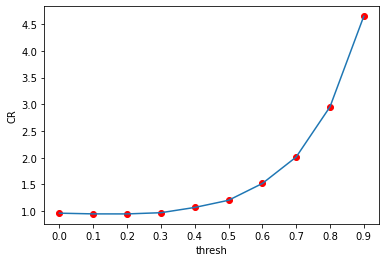

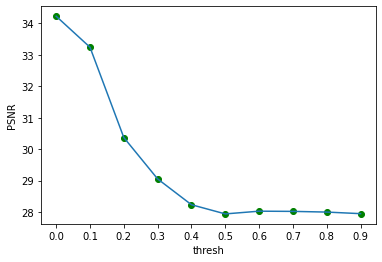

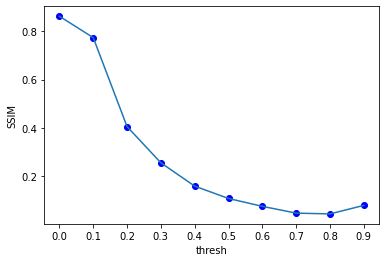

In [191]:
# folderName = 'Kodak'
# for fileName in (os.listdir(folderName)):
#     imagePath = os.path.join(folderName, fileName)
#     image = load_image(imagePath)
#     thresh = 0.0
#     threshMax = 0.9
#     step = 0.1
#     i=0
#     noOfMetrics = 3 
#     eval_data = np.zeros(((int((threshMax-thresh)/step))+1, noOfMetrics + 1), dtype=float)#col1=thresh, col2=cr, col3=psnr, col4=ssim
#     while thresh<=threshMax:
#       eval_data[i][0] = thresh
#       # print("Testing for threshold = "+str(thresh))
#       X_compressed = np.asarray(DCT_compression(image, thresh, 100, 100), dtype=None, order=None )#DCT Transform 
#       print("Metrics otained: ")
#       eval_data[i][1], eval_data[i][2], eval_data[i][3] = metrics( image, X_compressed )
#       thresh+=0.1
#       i+=1
#     print("Data obtained after evaluation: ")
#     print(eval_data)
#     PlotGraphs(np.ndarray.transpose(eval_data), 'thresh')

In [218]:
A = np.array([[1,0,0,0],
             [4,0,1,0]])
B = np.repeat(A[:, :, np.newaxis], 3, axis=2)

print(np.sum(B!=0))

9
